# Semana 1: Exploración del problema y del dataset

## Cargar librerías

In [ ]:
#%pip install biosppy pandas matplotlib
#%pip install wfdb


## Inspección básica del dataset

In [7]:

import wfdb
import pandas as pd
import os

# Cargar el archivo CSV curado
df_csv = pd.read_csv('ecg_rr_features_curado.csv') 


# Dataframe Completo

# # Listar archivos .hea en la carpeta data
# data_folder = 'data'
# hea_files = [f for f in os.listdir(data_folder) if f.endswith('.hea')]

# # escoger solo los primeros 10 archivos
# hea_files = hea_files[:10]

# print("Archivos")
# for file in hea_files:
#     print(file)

# # Cargar el primer archivo
# if hea_files:
#     record_name = os.path.join(data_folder, hea_files[0].replace('.hea', ''))
#     record = wfdb.rdrecord(record_name)
#     df = pd.DataFrame(record.p_signal, columns=record.sig_name)



In [ ]:
# Ver los datos del CSV curado
print("Datos del CSV curado:")
print(df_csv.head())
print(df_csv.describe())
print(df_csv.dtypes)


Datos del CSV curado:
      mean_rr     std_rr   skew_rr   kurt_rr   label
0  849.671415  37.965868  0.404165  3.097078  Normal
1  786.173570  87.045564  0.462868  3.968645    AFib
2  864.768854  49.730056  0.278733  2.297947  Normal
3  952.302986  28.845781  0.260759  2.672338    AFib
4  776.584663  66.450898  0.662505  2.607892    AFib
          mean_rr     std_rr    skew_rr    kurt_rr
count   30.000000  30.000000  30.000000  30.000000
mean   781.185310  47.576751   0.502577   2.979748
std     90.000643  18.622044   0.198397   0.908822
min    608.671976  10.806598  -0.023949   1.081229
25%    740.894910  35.817727   0.397172   2.620240
50%    776.585483  48.708545   0.505122   2.969387
75%    836.033535  60.893236   0.647542   3.287354
max    957.921282  87.045564   0.812929   5.463242
mean_rr    float64
std_rr     float64
skew_rr    float64
kurt_rr    float64
label       object
dtype: object


In [ ]:

# # Ver los datos del DataFrame completo 
# print(df.head())
# print(df.describe())

# # tipos de datos
# print(df.dtypes)

## Visualización de distribución

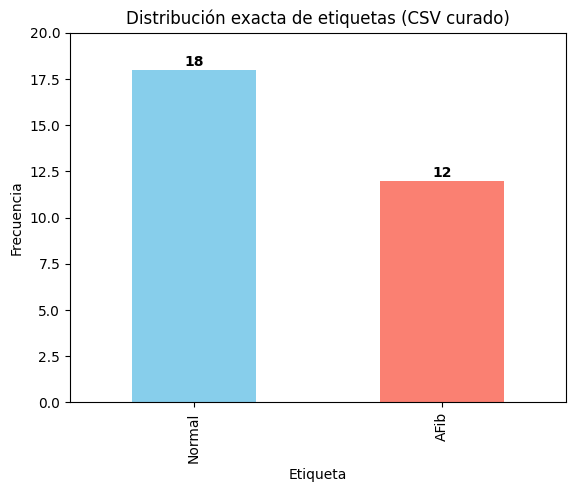

In [12]:
# visualizar distribución por etiqueta de csv curado
import matplotlib.pyplot as plt

# Graficar la distribución exacta de etiquetas con conteo
counts = df_csv['label'].value_counts()
counts.plot(kind='bar', color=['skyblue', 'salmon'])
for i, v in enumerate(counts):
    plt.text(i, v + 0.2, str(v), ha='center', fontweight='bold')
plt.title('Distribución exacta de etiquetas (CSV curado)')
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.ylim(0, counts.max() + 2)
plt.show()


## Conclusiones (CSV curado)
### ¿Qué variables parecen diferenciar más entre clases?
- La desviación estándar de Afib tiene valores más altos, habría mas variabilidad entre cada latido, los casos normales tendrían ritmos más estables.
- Skew-rr sería la asmietría, reflejaría latidos irregulares, mientras que los casos normales tienen una distribución más simétrica.
- mean_rr sería el promedio de intervalos RR, tiene algunos valores similares, la verdad no sería tan diferencial pero puede ayudar.
### ¿Qué aspectos del dataset llaman la atención?
- Existe desbalance de clases: 18 "Normal" y 12 "Afib", pero no sería crítico.
- Que la Curtosis (Kurt_rr) llegue a 5.46 indica que algunas señales podrían tener ruido o arritmias.
- std_rr sería el más discriminante porque muestra los latidos irregulares. 
